## 📦 Install Required Packages

These lines install the necessary Python libraries used in the project.
- `langchain`, `langgraph`, and related libraries are used for building a language model-based agent system.
- `chromadb` is used for vector storage and similarity search.
- `sentence-transformers` provides high-performance embeddings.
- `langsmith` enables observability and logging for LLM chains.
- `torch` and `tf-keras` are common deep learning frameworks.
- `pypdf` helps with PDF document handling.


In [ ]:
%pip install langchain langgraph langchain-community langchain-core
%pip install langchain-huggingface
%pip install chromadb
%pip install python-dotenv
%pip install sentence-transformers
%pip install -U langchain-ollama
%pip install langsmith
%pip install tf-keras
%pip install torch
%pip install pypdf
%pip install chromadb
%pip install langchain-core --upgrade

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 🔧 Import Libraries and Setup

This section includes:
- Core components from LangChain (e.g., message types, graph building, embedding models).
- Document loaders and text splitters for processing input files (like PDFs).
- Chroma for storing and searching vectorized documents.
- Environment variable loading using `dotenv`.
- Hugging Face and Ollama embedding models for text representation.


In [ ]:
## Imports and Initial Configuration

from typing import TypedDict, Sequence, Annotated, Literal
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langsmith import Client
import langsmith
import time
import json
from langchain_ollama import OllamaEmbeddings
import os
from dotenv import load_dotenv

## 🔐 Environment and LangSmith Configuration

This block loads secret keys and configures LangSmith (a LangChain observability platform) for tracking and debugging.
- It reads API keys from the `.env` file.
- It sets environment variables to enable tracing and associate runs with a specific project in LangSmith.

**Note**: The API key should ideally be stored securely and not hardcoded.


In [ ]:
# Load env variables
load_dotenv()

# LangSmith Configuration - Replace with your actual API key
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY", "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")
LANGSMITH_PROJECT = "hr-rag-agent-demo"
# Configure LangSmith environment for tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY
os.environ["LANGCHAIN_PROJECT"] = LANGSMITH_PROJECT

## 📄 Load and Split PDF Document

This block:
- Loads the HR policy or documentation PDF using `PyPDFLoader`
- Splits it into manageable text chunks with `RecursiveCharacterTextSplitter`
- Creates a local persistent vector store using `Chroma`
- Embeds each chunk using `OllamaEmbeddings`
- Converts the vector store into a retriever that supports semantic search

This enables the AI agent to retrieve relevant HR-related context when answering user queries.


In [ ]:
embeddings = OllamaEmbeddings(model="nomic-embed-text")

# Initialize Ollama LLM
llm = ChatOllama(
    model="llama3.1",  # Make sure this model is installed
    temperature=0
)

# Load and process HR PDF document
pdf_path = "HR_doc.pdf"
loader = PyPDFLoader(pdf_path)
pages = loader.load()
print(f"📄 PDF document loaded: {len(pages)} pages")

# Split documents into chunks for better retrieval
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    separators=["\n\n", "\n", ".", " "]
)
chunks = splitter.split_documents(pages)

# Setup vector store for document retrieval
persist_directory = "./chroma_db"  # Local directory for vector store
collection_name = "hr_documents"

if not os.path.exists(persist_directory):
    os.makedirs(persist_directory)

# Create vector store from document chunks
vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=embeddings,
    persist_directory=persist_directory,
    collection_name=collection_name
)

# Create retriever for similarity search
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})

print(f"✅ Processed {len(chunks)} document chunks")
print(f"🗂 Vector store created successfully")

📄 PDF document loaded: 24 pages
✅ Processed 81 document chunks
🗂 Vector store created successfully


## 🔧 Define a Custom Document Retrieval Tool

This is a custom tool decorated with `@tool` and `@langsmith.traceable` to enable LLMs to access document chunks:
- Takes in a natural language query
- Uses the retriever to fetch relevant text from the embedded document chunks
- Formats the output for clarity

This tool is accessible by the LLM agent during reasoning.


In [ ]:
@tool
@langsmith.traceable(name="hr_document_retrieval")  # LangSmith tracing decorator
def retriever_tool(query: str) -> str:
    """
    Search and return relevant information from the HR documents.
    This tool performs semantic search across the loaded HR document chunks.

    Args:
        query: The search query to find relevant HR information

    Returns:
        Formatted string with relevant document excerpts
    """
    try:
        # Retrieve relevant documents based on query
        docs = retriever.invoke(query)

        if not docs:
            return " No relevant information found in the HR documents."

        # Format retrieved documents for better readability
        formatted_results = []
        for i, doc in enumerate(docs, 1):
            formatted_results.append(f"📄 Source {i}:\n{doc.page_content.strip()}")

        return "\n\n" + "\n\n".join(formatted_results)

    except Exception as e:
        return f" Error retrieving documents: {str(e)}"


## 🧠 Define Agent State Structure

This class `AgentState` is a typed dictionary that defines the structure of the agent's memory and context. It tracks:
- `messages`: the history of conversation messages
- `retry_count` and `max_retries`: control logic in case of failures
- `last_error`: stores any recent error message
- `conversation_memory` and `user_context`: track contextual state over time


In [ ]:
@tool
@langsmith.traceable(name="fallback_general_response")
def fallback_tool(query: str) -> str:
    """
    Fallback tool that provides general HR guidance when document retrieval fails.
    """
    try:
        general_responses = {
            "vacation": "For vacation policies, please contact HR directly or check your employee handbook.",
            "sick": "For sick leave information, please refer to your employment contract or contact HR.",
            "benefits": "For detailed benefits information, please contact the HR department.",
            "remote": "For remote work policies, please check with your manager or HR department.",
            "policy": "For specific policy information, please consult your employee handbook or contact HR."
        }

        query_lower = query.lower()
        for key, response in general_responses.items():
            if key in query_lower:
                return f"🔄 Fallback Response: {response}"

        return "🔄 Fallback Response: I don't have specific information about that topic. Please contact HR directly for assistance."

    except Exception as e:
        return f" Fallback tool error: {str(e)}"


## 🔁 Define Agent Stopping Condition

This function decides what step to perform next. It looks at:
- Whether the LLM issued a tool call
- Retry limits (for fault tolerance)
- Conditions for ending the interaction or falling back to a simple response


In [ ]:
# Bind tools to LLM and create tools dictionary
tools = [retriever_tool, fallback_tool]
llm = llm.bind_tools(tools)
tools_dict = {tool.name: tool for tool in tools}

print(" HR retrieval and fallback tools created and bound to LLM")

 HR retrieval and fallback tools created and bound to LLM


## 🧩 Construct LangGraph Agent

Here we construct the LangGraph using:
- Nodes for the LLM, retriever, retry logic, and fallback logic
- Edges that direct flow based on tool calls, retries, and errors
- Final `compile()` step that produces an executable multi-step agent

This graph enables a reasoning loop where the LLM decides, retrieves, reasons again, and gracefully handles failures.


In [ ]:
class AgentState(TypedDict):
    """
    Enhanced agent state that maintains conversation history, memory, and retry logic.
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]
    retry_count: int
    max_retries: int
    last_error: str
    conversation_memory: dict
    user_context: dict

## 🔁 Define Agent Stopping Condition

This function decides what step to perform next. It looks at:
- Whether the LLM issued a tool call
- Retry limits (for fault tolerance)
- Conditions for ending the interaction or falling back to a simple response


In [ ]:
def should_continue(state: AgentState) -> Literal["retriever_agent", "retry_logic", "fallback_agent", "end"]:
    """
    Enhanced conditional routing function that determines next action based on:
    - Tool calls in last message
    - Retry count and errors
    - Whether fallback is needed
    """
    last_message = state['messages'][-1]
    retry_count = state.get('retry_count', 0)
    max_retries = state.get('max_retries', 2)

    # Check if there are tool calls
    has_tool_calls = hasattr(last_message, 'tool_calls') and len(last_message.tool_calls) > 0

    # If there's an error and we haven't exceeded retries
    if state.get('last_error') and retry_count < max_retries:
        return "retry_logic"

    # If we have tool calls and no errors, proceed with retrieval
    if has_tool_calls and not state.get('last_error'):
        return "retriever_agent"

    # If retries exceeded or specific conditions met, use fallback
    if retry_count >= max_retries or "fallback" in str(last_message.content).lower():
        return "fallback_agent"

    # Otherwise end the conversation
    return "end"

In [ ]:
# System prompt for HR assistant behavior
system_prompt = """
You are an intelligent HR assistant who answers questions about company policies,
procedures, and employee benefits based on the loaded HR documents.

🎯 Your responsibilities:
1. Use the retriever_tool to search for relevant information from HR documents
2. Provide accurate, helpful, and professional responses
3. Cite specific parts of the documents you use in your answers
4. If information is not found in the documents, clearly state this
5. Ask for clarification if the question is ambiguous
6. Remember previous conversations and build context
7. If you encounter errors, the system will retry or use fallback responses

Remember: You represent the company, so maintain a professional and helpful tone.
Always consider the conversation history when responding.
"""

In [ ]:
@langsmith.traceable(name="llm_reasoning")  # LangSmith tracing
def call_llm(state: AgentState) -> AgentState:
    """
    Enhanced LLM reasoning node with memory integration.
    """
    try:
        # Initialize state fields if not present
        if 'conversation_memory' not in state:
            state['conversation_memory'] = {}
        if 'user_context' not in state:
            state['user_context'] = {}

        # Extract user context from conversation history
        user_messages = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
        if user_messages:
            latest_query = user_messages[-1].content
            # Simple context extraction (could be enhanced with NLP)
            if 'vacation' in latest_query.lower():
                state['user_context']['topic'] = 'vacation'
            elif 'sick' in latest_query.lower():
                state['user_context']['topic'] = 'sick_leave'
            elif 'remote' in latest_query.lower():
                state['user_context']['topic'] = 'remote_work'

        # Prepare messages with system prompt and memory context
        memory_context = ""
        if state['conversation_memory']:
            memory_context = f"\n\nConversation Context: {json.dumps(state['conversation_memory'], indent=2)}"

        enhanced_system_prompt = system_prompt + memory_context
        messages = [SystemMessage(content=enhanced_system_prompt)] + list(state["messages"])

        # Get LLM response (may include tool calls)
        response = llm.invoke(messages)

        # Clear any previous errors on success
        return {
            "messages": [response],
            "last_error": "",
            "retry_count": 0
        }

    except Exception as e:
        error_message = AIMessage(content=f"❌ I encountered an error: {str(e)}")
        return {
            "messages": [error_message],
            "last_error": str(e),
            "retry_count": state.get('retry_count', 0)
        }

In [ ]:
@langsmith.traceable(name="tool_execution")  # LangSmith tracing
def take_action(state: AgentState) -> AgentState:
    """
    Enhanced tool execution node with error handling and memory updates.
    """
    try:
        # Get tool calls from the last message
        tool_calls = state["messages"][-1].tool_calls
        results = []

        # Execute each tool call
        for tool_call in tool_calls:
            tool_name = tool_call["name"]
            query = tool_call["args"].get("query", "")

            # Update conversation memory
            memory_update = {
                'last_query': query,
                'tool_used': tool_name,
                'timestamp': time.time()
            }

            if tool_name not in tools_dict:
                result = f"❌ Error: Invalid tool name '{tool_name}'"
            else:
                # Execute the tool
                result = tools_dict[tool_name].invoke(query)
                memory_update['result_preview'] = result[:100] + "..." if len(result) > 100 else result

            # Create tool message with result
            tool_message = ToolMessage(
                tool_call_id=tool_call["id"],
                name=tool_name,
                content=str(result)
            )
            results.append(tool_message)

        # Update state with memory
        updated_memory = state.get('conversation_memory', {})
        updated_memory.update(memory_update)

        return {
            "messages": results,
            "conversation_memory": updated_memory,
            "last_error": "",
            "retry_count": 0
        }

    except Exception as e:
        error_message = ToolMessage(
            tool_call_id="error",
            name="error",
            content=f"❌ Tool execution error: {str(e)}"
        )
        return {
            "messages": [error_message],
            "last_error": str(e),
            "retry_count": state.get('retry_count', 0)
        }

In [ ]:
@langsmith.traceable(name="retry_logic")
def retry_node(state: AgentState) -> AgentState:
    """
    Retry logic node that attempts to recover from errors.
    """
    try:
        retry_count = state.get('retry_count', 0) + 1
        last_error = state.get('last_error', '')

        print(f"🔄 Retry attempt {retry_count} due to error: {last_error}")

        # Add a retry message to help the LLM understand the context
        retry_message = SystemMessage(
            content=f"Previous attempt failed with error: {last_error}. Please try a different approach or use fallback if needed."
        )

        return {
            "messages": [retry_message],
            "retry_count": retry_count,
            "last_error": last_error
        }

    except Exception as e:
        return {
            "messages": [SystemMessage(content=f"Retry logic failed: {str(e)}")],
            "retry_count": state.get('retry_count', 0) + 1,
            "last_error": str(e)
        }

In [ ]:
@langsmith.traceable(name="fallback_response")
def fallback_node(state: AgentState) -> AgentState:
    """
    Fallback node that provides alternative responses when primary methods fail.
    """
    try:
        # Get the latest user question
        user_messages = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
        latest_query = user_messages[-1].content if user_messages else "general inquiry"

        # Use fallback tool
        fallback_result = fallback_tool.invoke(latest_query)

        fallback_message = AIMessage(
            content=f"{fallback_result}\n\n💡 Note: This is a fallback response. For more specific information, please contact HR directly."
        )

        return {
            "messages": [fallback_message],
            "last_error": "",
            "retry_count": 0
        }

    except Exception as e:
        error_message = AIMessage(
            content="❌ I apologize, but I'm experiencing technical difficulties. Please contact HR directly for assistance."
        )
        return {
            "messages": [error_message],
            "last_error": str(e)
        }

print("🔧 Enhanced workflow nodes defined with memory, retry, and fallback logic")

🔧 Enhanced workflow nodes defined with memory, retry, and fallback logic


## 🧩 Construct LangGraph Agent

Here we construct the LangGraph using:
- Nodes for the LLM, retriever, retry logic, and fallback logic
- Edges that direct flow based on tool calls, retries, and errors
- Final `compile()` step that produces an executable multi-step agent

This graph enables a reasoning loop where the LLM decides, retrieves, reasons again, and gracefully handles failures.


In [ ]:
# Create the enhanced workflow graph
graph = StateGraph(AgentState)

# Add all nodes to the graph
graph.add_node("llm", call_llm)
graph.add_node("retriever_agent", take_action)
graph.add_node("retry_logic", retry_node)
graph.add_node("fallback_agent", fallback_node)

# Add conditional edges for enhanced workflow routing
graph.add_conditional_edges(
    "llm",
    should_continue,
    {
        "retriever_agent": "retriever_agent",   # Use tools if LLM decides to
        "retry_logic": "retry_logic",           # Retry on errors
        "fallback_agent": "fallback_agent",     # Use fallback when needed
        "end": END                          # End conversation
    }
)

# After tool execution, return to LLM for response generation
graph.add_edge("retriever_agent", "llm")

# After retry, go back to LLM
graph.add_edge("retry_logic", "llm")

# After fallback, end the conversation
graph.add_edge("fallback_agent", END)

# Set the entry point
graph.set_entry_point("llm")

# Compile the enhanced graph into an executable agent
rag_agent = graph.compile()

print("✅ Enhanced LangGraph workflow compiled successfully with memory, retry, and fallback")

✅ Enhanced LangGraph workflow compiled successfully with memory, retry, and fallback


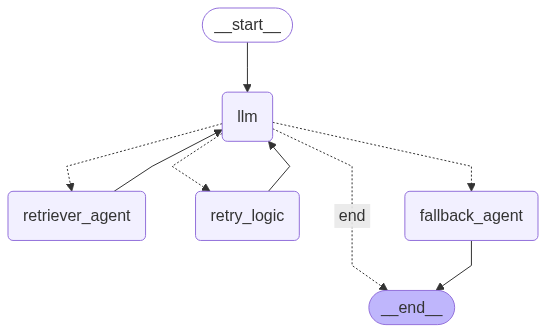

In [ ]:
## Visualize the Enhanced Workflow

from IPython.display import Image, display
display(Image(rag_agent.get_graph().draw_mermaid_png()))

## ▶️ Run a Test Query

This function `ask_hr_question()` allows you to:
- Send a question to the HR RAG agent
- Automatically initialize agent state (including memory, retries, etc.)
- Print the final AI-generated answer
- Optionally display internal details like number of retries, memory usage, and tools used

This function is useful for **testing your RAG agent in a structured way** before deploying it.


In [ ]:
## Enhanced Query Function

def ask_hr_question(question: str, show_details: bool = False):
    """
    Ask a question to the enhanced HR assistant with memory, retry, and fallback capabilities.
    All interactions are automatically traced to LangSmith.

    Args:
        question: The HR question to ask
        show_details: Whether to show internal workflow details

    Returns:
        The assistant's response
    """
    try:
        print(f"❓ Question: {question}")
        print("🤔 Processing with enhanced capabilities...")

        # Initialize state with enhanced fields
        initial_state = {
            "messages": [HumanMessage(content=question)],
            "retry_count": 0,
            "max_retries": 2,
            "last_error": "",
            "conversation_memory": {},
            "user_context": {}
        }

        # Run the query through the enhanced agent
        result = rag_agent.invoke(initial_state)

        # Extract the final response
        final_response = result["messages"][-1].content

        print(f"🤖 HR Assistant: {final_response}")

        if show_details:
            print(f"\n📊 Enhanced Workflow Details:")
            print(f"   • Total messages: {len(result['messages'])}")
            print(f"   • Retry attempts: {result.get('retry_count', 0)}")
            print(f"   • Memory entries: {len(result.get('conversation_memory', {}))}")
            print(f"   • User context: {result.get('user_context', {})}")
            print(f"   • Used tools: {any(hasattr(msg, 'tool_calls') and msg.tool_calls for msg in result['messages'] if hasattr(msg, 'tool_calls'))}")

        print(f"\n🔗 This interaction was traced to LangSmith with enhanced monitoring!")
        print(f"   Visit: https://smith.langchain.com/")
        print("=" * 60)

        return final_response

    except Exception as e:
        error_msg = f"❌ Error: {str(e)}"
        print(error_msg)
        return error_msg

In [ ]:
## Sample Queries and Results

# Test Query 1: Vacation Policy with Memory
ask_hr_question("What is the vacation policy?", show_details=True)

# Test Query 2: Sick Leave with Retry Demonstration
ask_hr_question("What symptoms may indicate alcohol misuse among employees?")

# Test Query 3: Remote Work with Fallback Testing
ask_hr_question("Can I work from home? What's the remote work policy?")

# Test Query 4: Benefits with Enhanced Context
ask_hr_question("What employee benefits does the company provide?")

# Test Query 5: Complex Query with Full Enhancement Features
ask_hr_question("I'm planning a 2-week vacation in December. What do I need to know about requesting time off and what happens to unused days?")

# Test Query 6: Force Fallback Response
ask_hr_question("What happens if an employee is under the influence of drugs while on duty?")

print("\n🎉 Enhanced HR RAG Agent Demo Complete!")
print("✅ Features demonstrated:")
print("   • Memory: Conversation context preserved")
print("   • Retry: Error recovery mechanisms")
print("   • Fallback: Alternative response strategies")
print("   • LangSmith: Full tracing and monitoring")
print("   • LangGraph: Visual workflow representation")

❓ Question: What is the vacation policy?
🤔 Processing with enhanced capabilities...
🤖 HR Assistant: Based on our company's policies (Source 1-3), it appears that there is no specific information provided about a traditional vacation policy. However, I did find some related information.

It seems that our company has a "garden leave" policy, which requires employees to stay away from the workplace during this period. This policy does not seem to be directly related to taking vacations or time off for leisure purposes.

If you are looking for information on vacation policies, I would recommend checking with your supervisor or HR representative for more details. They may be able to provide you with specific guidance on our company's vacation policies and procedures.

Please let me know if there is anything else I can help you with!

📊 Enhanced Workflow Details:
   • Total messages: 4
   • Retry attempts: 0
   • Memory entries: 4
   • User context: {'topic': 'vacation'}
   • Used tools: Tr